### 1) GET LIBRARY

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pandas as pd
np.random.seed(123)

### 2) GENERATE DATA

In [2]:
num_data = 10000
a = 0.25 
b = 2 

x = np.random.poisson(100, num_data)
x = x.reshape((-1,1))

y = a*x + b
y = y.reshape((-1,1))
y = y.astype(int)

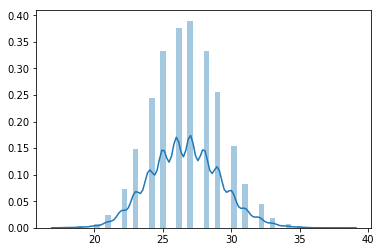

In [3]:
plt.figure()
sns.distplot(y)
plt.show()

### 3) IMPLEMENT SIMPLE PREDICTION

In [4]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [5]:
df_train = pd.DataFrame({'train_x': train_x.flatten(), 'train_y': train_y.flatten()})
df_test = pd.DataFrame({'test_x': test_x.flatten(), 'test_y': test_y.flatten()})

#### a) RANDOM FOREST

In [6]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_x, train_y)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [7]:
test_y_rfpred = (rf.predict(test_x)).astype(int)
err_rf = abs(test_y_rfpred - test_y)
print('Mean Absolute Error:', round(np.mean(err_rf), 2), 'degrees.')

('Mean Absolute Error:', 2.77, 'degrees.')


#### b) LINEAR REGRESSION

In [8]:
lr = LinearRegression()
lr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [9]:
test_y_lrpred = (rf.predict(test_x)).astype(int)
err_lr = abs(test_y_lrpred - test_y)
print('Mean Absolute Error:', round(np.mean(err_lr), 2), 'degrees.')

('Mean Absolute Error:', 2.77, 'degrees.')


In [10]:
print(lr.coef_) # check a
print(lr.intercept_) # check b

[[0.24940083]]
[1.68344031]


#### c) SUMMARIZE RESULT & CHECK GRAPH

In [11]:
df_summ = pd.DataFrame({'test_y': test_y.flatten(), 
                        'test_y_rfpred': test_y_rfpred.flatten(), 
                        'test_y_lrpred': test_y_lrpred.flatten()})
df_summ['actual_rf'] = df_summ['test_y_rfpred'] - df_summ['test_y']
df_summ['actual_lr'] = df_summ['test_y_lrpred'] - df_summ['test_y']
df_summ[(df_summ['actual_rf'] != 0) | (df_summ['actual_lr'] != 0)]

,test_y,test_y_lrpred,test_y_rfpred,actual_rf,actual_lr
1145,36,35,35,-1,-1


<Figure size 432x288 with 0 Axes>

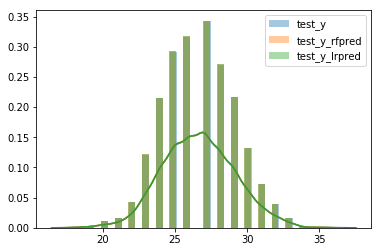

In [12]:
plt.figure()

components = [test_y, test_y_rfpred, test_y_lrpred]
labels=['test_y', 'test_y_rfpred', 'test_y_lrpred']

fig, axes = plt.subplots(1)
for component in components:
    sns.distplot(component)

axes.legend(labels=labels)    
plt.show()

### 4) STOCHASTIC PROGRAMMING
#### a) DISCRETIZING DEMAND

In [19]:
from sklearn.cluster import KMeans
from pulp import *

# do clustering to generate scenario (max 100 scenario for now)
def cluster_1d(df, max_cluster=100):
    km = KMeans(n_clusters=min(len(df.unique()),max_cluster))
    km.fit(df.values.reshape(-1,1)) 
    
    # get information about center
    cluster_centers_df = pd.DataFrame(np.array(km.cluster_centers_.reshape(1,-1)[0].tolist()))
    cluster_centers_df.columns = ['cluster_centers']
    cluster_centers_df['labels'] = range(cluster_centers_df.count())
    
    # get information about labels and add information about center
    cluster_labels_df = pd.DataFrame(np.array(km.labels_))
    cluster_labels_df.columns = ['labels']
    cluster_labels_df = pd.concat([df.reset_index(drop=True), cluster_labels_df], axis=1)
    cluster_labels_df = pd.merge(cluster_labels_df, cluster_centers_df, on='labels', how='left')
    
    return cluster_centers_df, cluster_labels_df

In [20]:
cluster_centers_df, cluster_labels_df = cluster_1d(df_train['train_y'])

count_label = cluster_labels_df[['labels']].count().values[0]
cluster_proportion_df = cluster_labels_df[['cluster_centers', 'labels']].groupby('cluster_centers').count().reset_index(drop=False)
cluster_proportion_df['count_labels'] = count_label
cluster_proportion_df['proportion_labels'] = cluster_proportion_df['labels'] / cluster_proportion_df['count_labels']
cluster_proportion_df['index'] = range(1,cluster_proportion_df.shape[0] + 1)
cluster_proportion_df['cluster_centers'] = np.round(cluster_proportion_df['cluster_centers'], decimals=(3))

In [44]:
demand = pd.Series(cluster_proportion_df['cluster_centers'].values, index=cluster_proportion_df['index'].values).to_dict()
weight = pd.Series(cluster_proportion_df['proportion_labels'].values, index=cluster_proportion_df['index'].values).to_dict()
scenarios = range(1,len(cluster_proportion_df.cluster_centers.values)+1)

In [45]:
print(demand)
print(weight)
print(scenarios)

{1: 18.0, 2: 19.0, 3: 20.0, 4: 21.0, 5: 22.0, 6: 23.0, 7: 24.0, 8: 25.0, 9: 26.0, 10: 27.0, 11: 28.0, 12: 29.0, 13: 30.0, 14: 31.0, 15: 32.0, 16: 33.0, 17: 34.0, 18: 35.0, 19: 38.0}
{1: 0.0005, 2: 0.000875, 3: 0.002625, 4: 0.010375, 5: 0.031, 6: 0.059875, 7: 0.0965, 8: 0.13225, 9: 0.1505, 10: 0.154375, 11: 0.13475, 12: 0.102125, 13: 0.0615, 14: 0.0325, 15: 0.017625, 16: 0.0075, 17: 0.003625, 18: 0.001375, 19: 0.000125}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


#### b) USING PULP TO SOLVE STOCHASTIC PROGRAMMING

In [23]:
N = 100

##########################################
# DEFINE VARIABLES
##########################################

M = LpProblem("Newsvendor1", LpMaximize)

x = LpVariable('x', lowBound=0)
z = LpVariable.dicts('z', scenarios, 0)
# s = LpVariable.dicts('s', scenarios)

##########################################
# DEFINE MODELS: OBJECTIVE + CONSTRAINTS
##########################################

for i in scenarios:
    print(demand[i])
    print(weight[i])
    M += x <= N
    M += z[i] <= x
    M += z[i] <= demand[i]
    
M += sum(weight[i] * (sell_price * z[i] + waste_price * (x - z[i])) for i in scenarios) - (cost_price * x) 
M.solve()


##########################################
# PRINT RESULTS
##########################################

print("Status = %s" % LpStatus[M.status])

print("%s = %f" % (x.name, x.varValue))
for i in scenarios:
    print("%s = %f" % (z[i].name, z[i].varValue))
print("Objective = %f" % (M.objective.value()))



18.0
0.0005
19.0
0.000875
20.0
0.002625
21.0
0.010375
22.0
0.031
23.0
0.059875
24.0
0.0965
25.0
0.13225
26.0
0.1505
27.0
0.154375
28.0
0.13475
29.0
0.102125
30.0
0.0615
31.0
0.0325
32.0
0.017625
33.0
0.0075
34.0
0.003625
35.0
0.001375
38.0
0.000125
Status = Optimal
x = 23.000000
z_1 = 18.000000
z_2 = 19.000000
z_3 = 20.000000
z_4 = 21.000000
z_5 = 22.000000
z_6 = 23.000000
z_7 = 23.000000
z_8 = 23.000000
z_9 = 23.000000
z_10 = 23.000000
z_11 = 23.000000
z_12 = 23.000000
z_13 = 23.000000
z_14 = 23.000000
z_15 = 23.000000
z_16 = 23.000000
z_17 = 23.000000
z_18 = 23.000000
z_19 = 23.000000
Objective = 21.621875


#### c) CHECK AS TABLE: TO SEE CLEARLY WHAT HAPPENS

In [67]:
purchase_df = pd.DataFrame({'key': 0, 'item_to_purchase': demand})
example_df = pd.DataFrame({'key': 0, 'item_to_sell': cluster_proportion_df['cluster_centers'], 
                   'probability': cluster_proportion_df['proportion_labels']})
example_df = example_df.merge(purchase_df, on='key', how='outer')
example_df = example_df.drop('key', axis=1).sort_values(['item_to_purchase', 'item_to_sell'])


In [72]:
example_df['total_revenue'] = example_df[['item_to_sell', 'item_to_purchase']].min(axis=1) * sell_price
example_df['total_cost'] = example_df['item_to_purchase'] * cost_price
example_df['total_profit'] = (example_df['total_revenue'] - example_df['total_cost'])
example_df['total_weighted_profit'] = example_df['probability'] * example_df['total_profit']
example_df['total_cumsum_profit'] = example_df.groupby('item_to_purchase')['total_weighted_profit'].cumsum()

example_df_summ = example_df.groupby('item_to_purchase', as_index=False)['total_weighted_profit'].sum()

In [104]:
temp = example_df[(example_df['item_to_purchase'] >= 20) & (example_df['item_to_purchase'] <= 25)]
temp.loc[:,'item_to_purchase'] = temp['item_to_purchase'].astype('str')

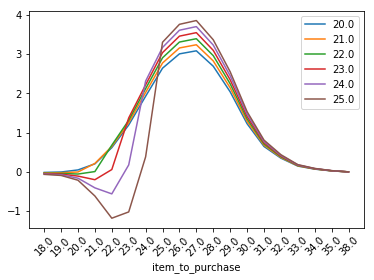

In [142]:
fig, ax = plt.subplots()

for i in temp['item_to_purchase'].unique():
    temp[temp['item_to_purchase'] == i].plot.line(x='item_to_purchase', y='total_weighted_profit', ax=ax, label=str(i))
plt.xticks(range(0,np.unique(temp['item_to_sell']).shape[0]),np.unique(temp['item_to_sell']),rotation=45)
plt.show()

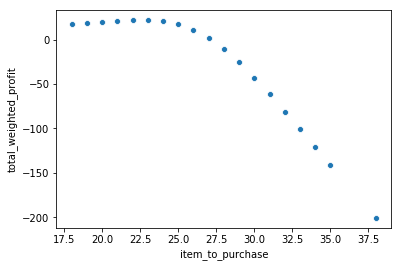

In [80]:
plt.figure()
sns.scatterplot(x='item_to_purchase', y='total_weighted_profit', data=example_df_summ)
plt.show()